returning to this approach after some delay working on neural network approaches

#### Online, we import the usual packages. **xgboost** needs to be installed (with conda install xgboost or pip install -U xgboost).

In [6]:
#!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/jjaskolkambp/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### now the usual imports

In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
import random as rn

from IPython.display import clear_output

In [64]:
def get_metrics(y_test, preds, print_output = False):
    f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, preds)
    prec = sklearn.metrics.precision_score(y_test,preds, average=None) 
    rec = sklearn.metrics.recall_score(y_test,preds, average=None)
    
    if print_output:
        print ('weighted f1: ', f1_w)
        print ('f1:          ', f1)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        print ('admission sens: ', rec[0])
        print ('admission spec: ', rec[1])
            
    return f1_w, f1, acc, prec, rec


In [65]:
def JJ_gridsearch(weights):
    epoch = 0
    for weight in weights:
        
        xgc = xgb.XGBClassifier(scale_pos_weight=weight)
        xgc.fit(X_train, y_train)
        preds = xgc.predict(X_test)
        f1_w, f1, acc, prec, rec = get_metrics(y_test, preds)
        
        if epoch == 0:
            results_df = pd.DataFrame([epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            results_df.columns = ['trial number', 'class penalty', 'weighted f1', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            results_df.loc[len(results_df)] = [epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]
        
        epoch +=1
        
    return results_df, preds

In [231]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'
model_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage/models'

clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [232]:
#clin = clin.sample(frac = 0.2)
clin.shape

(165433, 121)

In [233]:
clin.head()

,ID,ChartNumber,EncounterNumber,TriageLevel,AgeNumber,AgeInYrs,GenderDesc,PIA Date & Time,Disposition Date & Time,DischargeDisposition,...,Reg Date & Timeday_year_cos,Reg Date & Timeday_year_sin,Reg Date & Timehour_cos,Reg Date & Timehour_sin,Reg Date & Timeclock_cos,Reg Date & Timeclock_sin,Reg Date & Timemin_cos,Reg Date & Timemin_sin,Reg Date & Timesec_cos,Reg Date & Timesec_sin
0,149.0,N179474,NE000150/18,2.0,43.0,43.0,Female,01/04/2018 12:25:00PM,01/04/2018 2:30:00PM,17.0,...,0.998667,0.05162,-0.965926,0.258819,8.660254e-01,-0.500000,0.809017,-0.587785,1.0,0.0
1,198.0,N798201,NE000199/18,3.0,13.0,13.0,Female,01/04/2018 3:23:00PM,01/04/2018 4:13:00PM,17.0,...,0.998667,0.05162,-0.866025,-0.500000,5.000000e-01,0.866025,0.994522,0.104528,1.0,0.0
2,218.0,N798204,NE000225/18,2.0,23.0,23.0,Female,01/04/2018 3:00:00PM,01/04/2018 5:05:00PM,17.0,...,0.998667,0.05162,-0.707107,-0.707107,6.123234e-17,1.000000,0.406737,0.913545,1.0,0.0
3,219.0,N110229,NE000226/18,2.0,30.0,30.0,Female,01/04/2018 4:36:00PM,01/04/2018 11:00:00PM,17.0,...,0.998667,0.05162,-0.707107,-0.707107,6.123234e-17,1.000000,0.104528,0.994522,1.0,0.0
4,227.0,N739034,NE000222/18,4.0,36.0,36.0,Female,NaN,01/04/2018 3:30:00PM,63.0,...,0.998667,0.05162,-0.707107,-0.707107,6.123234e-17,1.000000,0.866025,0.500000,1.0,0.0


In [6]:
clin.columns[70:90]

Index(['Triage Date & TimeMinute', 'Triage Date & TimeSecond',
       'Triage Date & TimeElapsed', 'Triage Date & Timeweekday_cos',
       'Triage Date & Timeweekday_sin', 'Triage Date & Timeday_month_cos',
       'Triage Date & Timeday_month_sin', 'Triage Date & Timemonth_year_cos',
       'Triage Date & Timemonth_year_sin', 'Triage Date & Timeday_year_cos',
       'Triage Date & Timeday_year_sin', 'Triage Date & Timehour_cos',
       'Triage Date & Timehour_sin', 'Triage Date & Timeclock_cos',
       'Triage Date & Timeclock_sin', 'Triage Date & Timemin_cos',
       'Triage Date & Timemin_sin', 'Triage Date & Timesec_cos',
       'Triage Date & Timesec_sin', 'Reg Date & TimeYear'],
      dtype='object')

#### sanity checking the outcome variables

In [234]:
Counter(clin['ICUvsother']), Counter(clin['target5'])

(Counter({'0': 165168, 'INTENSIVE CARE UNIT': 265}),
 Counter({0.0: 165168, 1.0: 265}))

In [235]:
Counter(clin['discharge']), Counter(clin['target3'])

(Counter({'discharge': 149218, 'admit': 16215}),
 Counter({1.0: 149218, 0.0: 16215}))

#### creating the variables

In [88]:
len(set(clin['PresentingComplaint'])), len(set(clin['MainDiagnosisCode']))

(169, 3533)

In [237]:
dx_code_dict = {code:i for i,code in enumerate(set(clin['MainDiagnosisCode']))}

def convert_dxcode(s):
    code = dx_code_dict[s]
    return (code)

clin['recoded_diagnosis'] = clin['MainDiagnosisCode'].map(convert_dxcode)

In [178]:
dx_vars = ['recoded_diagnosis', 'PresentingComplaint']

In [179]:
cont_vars = [
 'Triage Date & TimeYear', 'Triage Date & TimeMonth', 'Triage Date & TimeWeek', 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek', 'Triage Date & TimeDayofyear', 'Triage Date & TimeHour', 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond', 'Triage Date & TimeElapsed',

 'recoded_diagnosis',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']


In [11]:
cos_date_vars = ['Triage Date & Timeweekday_cos',
       'Triage Date & Timeweekday_sin', 'Triage Date & Timeday_month_cos',
       'Triage Date & Timeday_month_sin', 'Triage Date & Timemonth_year_cos',
       'Triage Date & Timemonth_year_sin', 'Triage Date & Timeday_year_cos',
       'Triage Date & Timeday_year_sin', 'Triage Date & Timehour_cos',
       'Triage Date & Timehour_sin', 'Triage Date & Timeclock_cos',
       'Triage Date & Timeclock_sin', 'Triage Date & Timemin_cos',
       'Triage Date & Timemin_sin', 'Triage Date & Timesec_cos']

In [107]:
cat_vars =[
 'Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'GenderDesc']

#removed these last 2 and put them into the cont vars temporarily 'PresentingComplaintDesc', 'MainDiagnosisCodeDesc',



In [13]:
inf_control_vars = ['Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply']

In [142]:
len(set(clin['If so, select all countries that apply']))

203

In [143]:
len(set(clin['If so, select all infectious diseases that apply']))

5

### First, we don't use ANY NLP stuff.

let's remember this dictionary so we know what the various targets are:

outcome: {'discharge': 106689, 'madmit': 12037, 'sadmit': 2061, 'ICU': 479}

service: {'discharge': 106689, 'madmit': 12003, 'sadmit': 2278, 'ICU': 296}

discharge: {'discharge': 106689, 'admit': 14577}

dispo: {nan: 106689, 'madmit': 12037, 'sadmit': 2061, 'ICU': 479})(for admitted patients only, where did they go?

ICUvsother:  self explanatory

In [14]:
features = clin[cont_vars].values

In [15]:
target = clin['discharge']
target2 = clin['ICUvsother'] 

In [57]:
#X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [16]:
LABELS = ['admit', 'discharge'] 

In [59]:
y_train.value_counts()

discharge    111906
admit         12168
Name: discharge, dtype: int64

In [60]:
y_test.value_counts()

discharge    37312
admit         4047
Name: discharge, dtype: int64

#### first we are going to train xgb without class penalties

In [61]:
xgc = xgb.XGBClassifier()

%time xgc.fit(X_train, y_train)

CPU times: user 11.4 s, sys: 22.8 ms, total: 11.4 s
Wall time: 11.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [62]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


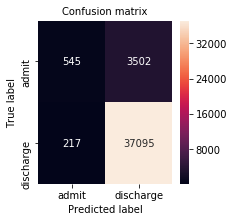

In [63]:
conf = confusion_matrix(y_test, preds)
plt.figure(figsize=(3, 3))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [64]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission PPV: ', rec[1])

weighted f1:  0.8812638450722602
f1:           [0.22665835 0.95226482]
accuracy:     0.9100800309485239
precision:    [0.7152231  0.91373747]
recall:       [0.13466766 0.99418418]
admission sens:  0.13466765505312578
admission PPV:  0.9941841766723842


#### now we are going to try with an empiric class penality

In [30]:
class_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]; class_ratio

9.387811634349031

In [31]:
xgc = xgb.XGBClassifier(scale_pos_weight=1/class_ratio)

%time xgc.fit(X_train, y_train)

CPU times: user 628 ms, sys: 6.82 ms, total: 635 ms
Wall time: 656 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.10652109766892888, seed=None,
       silent=None, subsample=1, verbosity=1)

In [32]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


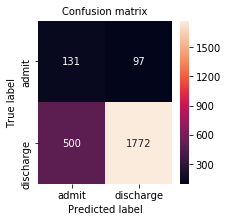

In [33]:
conf = confusion_matrix(y_test, preds)

plt.figure(figsize=(3, 3))

sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [34]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])

weighted f1:  0.8055965839770892
f1:           [0.30500582 0.85583192]
accuracy:     0.7612
precision:    [0.20760697 0.94810059]
recall:       [0.5745614  0.77992958]
admission sens:  0.5745614035087719
admission spec:  0.7799295774647887


#### gonna make my own "grid search to find best class penalty

In [66]:
weights = [1/90, 1/30, 1/9, 1/3, 1, 3, 9, 30, 90]

In [94]:
results_df, preds = JJ_gridsearch(weights)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

In [97]:
results_df

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.144802,"[0.18958392035315114, 0.13994517817094443]",0.165502,"[0.10474559559949145, 0.9964513839602555]","[0.9975290338522362, 0.07525728987993138]",0.997529,0.0752573
1,2,30,0.450971,"[0.23184091450345315, 0.4747384277164842]",0.376097,"[0.1317989507530885, 0.9870492635855764]","[0.9621942179392142, 0.31252680102915953]",0.962194,0.312527
2,3,9,0.80433,"[0.36456733230926774, 0.8520284973321012]",0.759956,"[0.2460050099334888, 0.9597407830233027]","[0.7037311588831233, 0.7660538164665524]",0.703731,0.766054
3,4,3,0.888972,"[0.37997658079625296, 0.9441794270352898]",0.89758,"[0.4660682226211849, 0.9287343806709182]","[0.3207314059797381, 0.9601468696397941]",0.320731,0.960147
4,5,1,0.881264,"[0.22665834892909129, 0.9522648217792552]",0.91008,"[0.7152230971128609, 0.9137374682858339]","[0.13466765505312578, 0.9941841766723842]",0.134668,0.994184
5,6,0.333333,0.866207,"[0.08911819887429642, 0.9504932826879445]",0.906091,"[0.8755760368663594, 0.9062515191288707]","[0.046948356807511735, 0.9992763722126929]",0.0469484,0.999276
6,7,0.111111,0.858345,"[0.02197802197802198, 0.94906070742658]",0.903165,"[0.9375, 0.9031250756457118]","[0.01111934766493699, 0.9999195969125214]",0.0111193,0.99992
7,8,0.0333333,0.856332,"[0.004929751047572098, 0.9486785065025871]",0.902391,"[1.0, 0.9023676509710029]","[0.002470966147763776, 1.0]",0.00247097,1
8,9,0.0111111,0.856155,"[0.003453379378391712, 0.9486423268585376]",0.902319,"[1.0, 0.902302186109499]","[0.001729676303434643, 1.0]",0.00172968,1


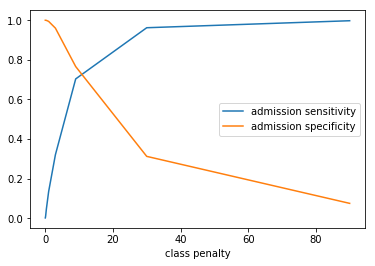

In [114]:
results_df.plot(x = 'class penalty', y = ['admission sensitivity', 'admission specificity'] )
plt.show()

#### assessing the impact of different sets of continuous variables
from this work it looks like the ideal class penalty is 9 (corresponding to a scale pos weight of 1/9).  gonna try to see the impact of adding some continous variables to see the effect

##### standard continuous variables

In [17]:
features = clin[cont_vars].values
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [20]:
#new baseline (with new smaller feature set) without class penalty
xgc = xgb.XGBClassifier()

%time xgc.fit(X_train, y_train)

CPU times: user 8.19 s, sys: 21.6 ms, total: 8.21 s
Wall time: 8.22 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [21]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


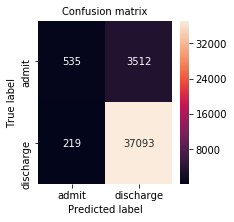

In [22]:
conf = confusion_matrix(y_test, preds)

plt.figure(figsize=(3, 3))

sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [23]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])

weighted f1:  0.8807586576388656
f1:           [0.22287024 0.95211571]
accuracy:     0.9097898885369569
precision:    [0.70954907 0.91350819]
recall:       [0.13219669 0.99413057]
admission sens:  0.132196688905362
admission spec:  0.9941305746140652


In [24]:
#repeat with best class penalty
xgc = xgb.XGBClassifier(scale_pos_weight = 1/9)

%time xgc.fit(X_train, y_train)

CPU times: user 8.2 s, sys: 29.5 ms, total: 8.23 s
Wall time: 8.24 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [25]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


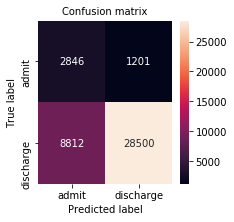

In [26]:
conf = confusion_matrix(y_test, preds)

plt.figure(figsize=(3, 3))

sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [27]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])

weighted f1:  0.8028156043067411
f1:           [0.36243235 0.85058123]
accuracy:     0.7579003360816268
precision:    [0.24412421 0.95956365]
recall:       [0.70323697 0.76382933]
admission sens:  0.7032369656535705
admission spec:  0.7638293310463122


##### first mixing of class variables

In [45]:
features = (clin[cont_vars + cos_date_vars]).values
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [50]:
#new baseline (with new smaller feature set) without class penalty
xgc = xgb.XGBClassifier(scale_pos_weight = 1/9)

%time xgc.fit(X_train, y_train)

CPU times: user 12 s, sys: 42 ms, total: 12 s
Wall time: 12 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [51]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


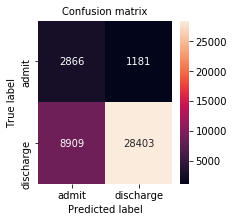

In [52]:
conf = confusion_matrix(y_test, preds)

plt.figure(figsize=(3, 3))

sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [53]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])

weighted f1:  0.8015265631526567
f1:           [0.36228037 0.84916886]
accuracy:     0.7560385889407384
precision:    [0.24339703 0.96007977]
recall:       [0.7081789  0.76122963]
admission sens:  0.708178897949098
admission spec:  0.7612296312178388


so effectively adding the cosine date variables to the mix does nothing. Probably becuase they are similar to the other engineered date variables.   Gonna try now to see if theres an effect of replacing the reg date vars with cosine stuff

##### removed redundant engineered date variables

In [57]:
cont_vars =  ['AgeNumber','num_comorbids',
 'systolic',
 'diastolic',
 'o2sat',
 'pulse',
 'temp',
 'AgeInYrs']

In [58]:
features = (clin[cont_vars + cos_date_vars]).values
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [59]:
xgc = xgb.XGBClassifier(scale_pos_weight = 1/9)

%time xgc.fit(X_train, y_train)

CPU times: user 10.2 s, sys: 86.3 ms, total: 10.3 s
Wall time: 10.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [60]:
preds = xgc.predict(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


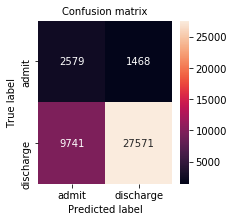

In [61]:
conf = confusion_matrix(y_test, preds)

plt.figure(figsize=(3, 3))

sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [62]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission spec: ', rec[1])

weighted f1:  0.7805821697762488
f1:           [0.31514633 0.83106509]
accuracy:     0.7289828090621147
precision:    [0.20933442 0.9494473 ]
recall:       [0.63726217 0.73893117]
admission sens:  0.6372621695082777
admission spec:  0.7389311749571184


#### weird worse performance...time to reintroduce my gridsearch thingy...

In [67]:
weights = [1/90, 1/30, 1/9, 1/3, 1]

In [68]:
results_df, preds = JJ_gridsearch(weights)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

In [69]:
results_df

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.0182222,"[0.17832121612690022, 0.0008572653236176598]",0.0982374,"[0.09788839706842754, 1.0]","[1.0, 0.0004288164665523156]",1,0.000428816
1,2,30,0.328104,"[0.20581333333333335, 0.3413684815781326]",0.279915,"[0.11535587241801931, 0.9762205919554768]","[0.953545836422041, 0.20685034305317324]",0.953546,0.20685
2,3,9,0.780582,"[0.31514633103195455, 0.8310650932163796]",0.728983,"[0.2093344155844156, 0.9494472950170461]","[0.6372621695082777, 0.7389311749571184]",0.637262,0.738931
3,4,3,0.878498,"[0.315554231227652, 0.9395574033628924]",0.888924,"[0.3973733583489681, 0.9227787253837805]","[0.26167531504818387, 0.9569575471698113]",0.261675,0.956958
4,5,1,0.870981,"[0.14257512612415005, 0.9499865658465436]",0.905486,"[0.634765625, 0.9088794770729797]","[0.08030639980232271, 0.9949882075471698]",0.0803064,0.994988


#### so that sucked!  Going back to my original set of continuous variables

In [73]:
features = (clin[cont_vars + cos_date_vars]).values
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [74]:
results_df, preds = JJ_gridsearch(weights)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

In [75]:
results_df

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.153539,"[0.1904716958871139, 0.14953271028037382]",0.170507,"[0.10529061880413232, 0.9963660389824909]","[0.9972819372374598, 0.08083190394511149]",0.997282,0.0808319
1,2,30,0.45984,"[0.23361086897712585, 0.484377843839107]",0.38352,"[0.13298199986311682, 0.9867347779517179]","[0.9602174450210033, 0.32096912521440824]",0.960217,0.320969
2,3,9,0.801527,"[0.3622803691063077, 0.8491688591246114]",0.756039,"[0.24339702760084925, 0.9600797728501893]","[0.708178897949098, 0.7612296312178388]",0.708179,0.76123
3,4,3,0.888797,"[0.37733627667402503, 0.9442724865982641]",0.897701,"[0.46652110625909754, 0.92838828313175]","[0.31677786014331605, 0.9607096912521441]",0.316778,0.96071
4,5,1,0.880964,"[0.22439633638634468, 0.952178042457068]",0.909911,"[0.7120211360634082, 0.9136003152554062]","[0.1331850753644675, 0.9941573756432247]",0.133185,0.994157


#### back to baseline.  gonna confirm for myself that the cosine date stuff adds nothing

In [76]:
features = (clin[cont_vars + cos_date_vars]).values
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.153539,"[0.1904716958871139, 0.14953271028037382]",0.170507,"[0.10529061880413232, 0.9963660389824909]","[0.9972819372374598, 0.08083190394511149]",0.997282,0.0808319
1,2,30,0.45984,"[0.23361086897712585, 0.484377843839107]",0.38352,"[0.13298199986311682, 0.9867347779517179]","[0.9602174450210033, 0.32096912521440824]",0.960217,0.320969
2,3,9,0.801527,"[0.3622803691063077, 0.8491688591246114]",0.756039,"[0.24339702760084925, 0.9600797728501893]","[0.708178897949098, 0.7612296312178388]",0.708179,0.76123
3,4,3,0.888797,"[0.37733627667402503, 0.9442724865982641]",0.897701,"[0.46652110625909754, 0.92838828313175]","[0.31677786014331605, 0.9607096912521441]",0.316778,0.96071
4,5,1,0.880964,"[0.22439633638634468, 0.952178042457068]",0.909911,"[0.7120211360634082, 0.9136003152554062]","[0.1331850753644675, 0.9941573756432247]",0.133185,0.994157


#### so the cosine date stuff is totally redundant.  I wonder what the the change in cont vars created the difference.  gonna experiment

In [83]:
orig_cont_vars = [
 'Triage Date & TimeYear', 'Triage Date & TimeMonth', 'Triage Date & TimeWeek', 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek', 'Triage Date & TimeDayofyear', 'Triage Date & TimeHour', 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond', 'Triage Date & TimeElapsed',


 'PresentingComplaint',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']


In [77]:
#dropping presenting complaint variable

cont_vars = [
 'AgeNumber',
    
 'Triage Date & TimeYear', 'Triage Date & TimeMonth', 'Triage Date & TimeWeek', 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek', 'Triage Date & TimeDayofyear', 'Triage Date & TimeHour', 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond', 'Triage Date & TimeElapsed',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']

In [78]:
features = (clin[cont_vars]).values
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.0174914,"[0.17826230591344566, 5.36006217672125e-05]",0.0978747,"[0.09785289424053388, 1.0]","[1.0, 2.6801029159519725e-05]",1,2.6801e-05
1,2,30,0.33321,"[0.20656044985941893, 0.3469464218808542]",0.283566,"[0.1158327827497147, 0.9764297233593847]","[0.9530516431924883, 0.21095090051457976]",0.953052,0.210951
2,3,9,0.780468,"[0.31526251526251525, 0.8309264674846994]",0.728814,"[0.20935700964890944, 0.9495280093709089]","[0.6380034593526068, 0.7386631646655232]",0.638003,0.738663
3,4,3,0.878454,"[0.3143582847751382, 0.9396382768826044]",0.889045,"[0.3975812547241119, 0.9226358070932245]","[0.2599456387447492, 0.9572791595197255]",0.259946,0.957279
4,5,1,0.871032,"[0.14388803848677018, 0.9499008253887005]",0.905341,"[0.6254752851711026, 0.9089461954791468]","[0.08129478626142822, 0.9947201972555746]",0.0812948,0.99472


#### that has some negative effect.  now gonna drop one of the age columns, as well

In [81]:
cont_vars = ['Triage Date & TimeYear', 'Triage Date & TimeMonth', 'Triage Date & TimeWeek', 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek', 'Triage Date & TimeDayofyear', 'Triage Date & TimeHour', 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond', 'Triage Date & TimeElapsed',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']

features = (clin[cont_vars]).values
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.0177311,"[0.17824181149364524, 0.00032155202443795384]",0.0979714,"[0.09784290965370478, 0.8571428571428571]","[0.9997529033852236, 0.00016080617495711836]",0.999753,0.000160806
1,2,30,0.331059,"[0.20643574941201626, 0.34457639839300697]",0.282091,"[0.11573616230633223, 0.976846057571965]","[0.9542871262663701, 0.20918203259005147]",0.954287,0.209182
2,3,9,0.781126,"[0.3159762589487854, 0.8315781544256121]",0.729708,"[0.20998698763825635, 0.9495922650793105]","[0.6380034593526068, 0.7396548027444254]",0.638003,0.739655
3,4,3,0.878049,"[0.31402257872846107, 0.9392256468296791]",0.888344,"[0.39366852886405956, 0.9226870765889228]","[0.26118112181863107, 0.9563679245283019]",0.261181,0.956368
4,5,1,0.870615,"[0.14000438885231514, 0.9498599045559806]",0.905244,"[0.6254901960784314, 0.9087370559866826]","[0.07882382011366444, 0.9948810034305318]",0.0788238,0.994881


#### gonna put back presenting complaint before moving on

In [84]:
cont_vars = orig_cont_vars

features = (clin[cont_vars]).values
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.158985,"[0.19097666051223786, 0.1555149238980036]",0.173626,"[0.10560485876593628, 0.9958860759493671]","[0.996787744007907, 0.08434283876500857]",0.996788,0.0843428
1,2,30,0.457981,"[0.23320134389248862, 0.4823619942489166]",0.381948,"[0.13271193963604083, 0.9867439933719967]","[0.9604645416357795, 0.31920025728987994]",0.960465,0.3192
2,3,9,0.801549,"[0.3617034740239195, 0.8492565194649928]",0.756111,"[0.24310990132698196, 0.9598351518427186]","[0.7062021250308871, 0.7615244425385935]",0.706202,0.761524
3,4,3,0.888959,"[0.3795427901524033, 0.944211663636124]",0.897628,"[0.4663305725603169, 0.9286714011715308]","[0.31999011613540895, 0.9602808747855918]",0.31999,0.960281
4,5,1,0.880955,"[0.22508305647840532, 0.9520936561320634]",0.909766,"[0.7048114434330299, 0.9136486819413648]","[0.13392636520879664, 0.9939161663807891]",0.133926,0.993916


#### OK.  back to baseline. 

I learned through all that that the cosine date variables are redundant and that the presenting complaint variable is very important.  Interesting that its a categorical variable not handled particularly well.

By that logic, I want to see if the main diagnosis code can be handled the same way

In [104]:
cont_vars = orig_cont_vars + ['recoded_diagnosis']

features = (clin[cont_vars]).values
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.153238,"[0.1903975463017577, 0.14920784469293136]",0.170314,"[0.10524805675830769, 0.9960278053624627]","[0.9970348406226834, 0.08064429674099485]",0.997035,0.0806443
1,2,30,0.502115,"[0.24501370639947065, 0.530001373060552]",0.420658,"[0.14041170097508127, 0.9883678396371351]","[0.9607116382505559, 0.36208190394511147]",0.960712,0.362082
2,3,9,0.811306,"[0.38450649852013896, 0.8575979516493984]",0.768708,"[0.2599391039582427, 0.9645392445754085]","[0.7383246849518161, 0.7720036449399656]",0.738325,0.772004
3,4,3,0.895725,"[0.4220844745567248, 0.9470975574352409]",0.903068,"[0.5065743944636678, 0.9328550261249318]","[0.3617494440326168, 0.9617817324185248]",0.361749,0.961782
4,5,1,0.884107,"[0.24752475247524752, 0.9531526903814049]",0.911797,"[0.7490636704119851, 0.9150106021006953]","[0.14825796886582654, 0.9946129931389366]",0.148258,0.994613


#### and it clearly can be.  also improves the results...

gonna move on to categorical variables again

In [113]:
X = clin[cat_vars].values.astype(str)

features = []
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    features.append(feature)
encoded_x = np.array(features)
encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

In [115]:
features = (encoded_x)
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  '

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
1,2,30,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
2,3,9,0.825901,"[0.10036565376371201, 0.9045957185072273]",0.827486,"[0.10247167868177137, 0.902628418945964]","[0.09834445268099827, 0.9065716123499142]",0.0983445,0.906572
3,4,3,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1
4,5,1,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1


pretty weak if we don't one hot encode them

In [122]:
X = clin[cat_vars].values.astype(str)
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: : ", encoded_x.shape)

X shape: :  (165433, 16)


In [123]:
features = (encoded_x)
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  '

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
1,2,30,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
2,3,9,0.616744,"[0.17297614555821073, 0.664877261530621]",0.52303,"[0.10416035544784409, 0.9079478494873103]","[0.5097603162836669, 0.5244693396226415]",0.50976,0.524469
3,4,3,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1
4,5,1,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1


#### still weak with the one hot encoding. This is because the main things that need encoding are the presenting complaint and the main diagnosis code.  will come back to this later.  plan is to try to make a specific category of features for them and see how they behave

but first (!) - let's try to mix categorical and non categorical features and see what happens

In [126]:
features = np.concatenate((encoded_x,clin[cont_vars].values), axis =1)
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.15127,"[0.1901866515837104, 0.14704860249218088]",0.169177,"[0.10511918718249316, 0.995965030262273]","[0.9970348406226834, 0.07938464837049743]",0.997035,0.0793846
1,2,30,0.504271,"[0.24533131102474162, 0.5323569148832018]",0.422544,"[0.14065217391304347, 0.9880078494076604]","[0.9592290585618977, 0.3643331903945112]",0.959229,0.364333
2,3,9,0.813654,"[0.38854328667703475, 0.8597628035549744]",0.771851,"[0.2633289415898111, 0.9650030026022552]","[0.7407956510995799, 0.7752197684391081]",0.740796,0.77522
3,4,3,0.895516,"[0.4222158438576349, 0.9468514851485148]",0.902657,"[0.5035946593632318, 0.9329829855871794]","[0.3634791203360514, 0.9611385077186964]",0.363479,0.961139
4,5,1,0.884006,"[0.24789311408016448, 0.9530011688695362]",0.911531,"[0.7371638141809291, 0.9150489627784218]","[0.14899925871015568, 0.9942377787307033]",0.148999,0.994238


#### now adding back in the infection control variables
first time all of them.  

later will get rid of the where did you travel data becuase I bet it adds noise not useful info

In [140]:
X = clin[cat_vars + inf_control_vars].values.astype(str)
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: : ", encoded_x.shape)

X shape: :  (165433, 262)


In [128]:
features = np.concatenate((encoded_x,clin[cont_vars].values), axis =1)
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.15127,"[0.1901866515837104, 0.14704860249218088]",0.169177,"[0.10511918718249316, 0.995965030262273]","[0.9970348406226834, 0.07938464837049743]",0.997035,0.0793846
1,2,30,0.499558,"[0.24443257844646168, 0.5272302038088874]",0.418385,"[0.1400143936667866, 0.9885032058368339]","[0.9614529280948851, 0.35948220411663806]",0.961453,0.359482
2,3,9,0.813654,"[0.38854328667703475, 0.8597628035549744]",0.771851,"[0.2633289415898111, 0.9650030026022552]","[0.7407956510995799, 0.7752197684391081]",0.740796,0.77522
3,4,3,0.895516,"[0.4222158438576349, 0.9468514851485148]",0.902657,"[0.5035946593632318, 0.9329829855871794]","[0.3634791203360514, 0.9611385077186964]",0.363479,0.961139
4,5,1,0.883429,"[0.24282469543671278, 0.9529117174959871]",0.911337,"[0.7386934673366834, 0.9147252422158124]","[0.14529280948851, 0.9944253859348199]",0.145293,0.994425


#### I modified the cont vars again to include the main diagnosis code again.  This should be the best I can do for now...

next move will be to take them out of cont vars, one hot encode them and train on them with and without the other variables I already created

In [131]:
features = np.concatenate((encoded_x,clin[cont_vars].values), axis =1)
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth 

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.15127,"[0.1901866515837104, 0.14704860249218088]",0.169177,"[0.10511918718249316, 0.995965030262273]","[0.9970348406226834, 0.07938464837049743]",0.997035,0.0793846
1,2,30,0.499558,"[0.24443257844646168, 0.5272302038088874]",0.418385,"[0.1400143936667866, 0.9885032058368339]","[0.9614529280948851, 0.35948220411663806]",0.961453,0.359482
2,3,9,0.813654,"[0.38854328667703475, 0.8597628035549744]",0.771851,"[0.2633289415898111, 0.9650030026022552]","[0.7407956510995799, 0.7752197684391081]",0.740796,0.77522
3,4,3,0.895516,"[0.4222158438576349, 0.9468514851485148]",0.902657,"[0.5035946593632318, 0.9329829855871794]","[0.3634791203360514, 0.9611385077186964]",0.363479,0.961139
4,5,1,0.883429,"[0.24282469543671278, 0.9529117174959871]",0.911337,"[0.7386934673366834, 0.9147252422158124]","[0.14529280948851, 0.9944253859348199]",0.145293,0.994425


In [134]:
diag_vars  = ['recoded_diagnosis', 'PresentingComplaint']
ltd_cont_vars = ['Triage Date & TimeYear',
 'Triage Date & TimeMonth',
 'Triage Date & TimeWeek',
 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek',
 'Triage Date & TimeDayofyear',
 'Triage Date & TimeHour',
 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond',
 'Triage Date & TimeElapsed',
 'num_comorbids',
 'systolic',
 'diastolic',
 'o2sat',
 'pulse',
 'temp',
 'AgeInYrs']

In [135]:
#this should be the same as the non-penalized one from above
features = np.concatenate((encoded_x,clin[diag_vars].values, clin[ltd_cont_vars].values), axis =1)
weights = [1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,1,0.883429,"[0.24282469543671278, 0.9529117174959871]",0.911337,"[0.7386934673366834, 0.9147252422158124]","[0.14529280948851, 0.9944253859348199]",0.145293,0.994425


#### so this matches.  gonna play specifically with one hot encoding the main diagnosis and presenting complaint codes

In [136]:
X2 = clin[diag_vars].values.astype(str)
encoded_x2 = None
for i in range(0, X2.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X2[:,i])
	feature = feature.reshape(X2.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x2 is None:
		encoded_x2 = feature
	else:
		encoded_x2 = np.concatenate((encoded_x2, feature), axis=1)
print("X shape: : ", encoded_x2.shape)

X shape: :  (165433, 3702)


In [138]:
#since this is so huge, for the first time I train it, I'm gonna shrink it for faster processing
features = encoded_x2
weights = [1/90, 1/30, 1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features[:10000], target[:10000], random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  '

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,90,0.0191655,"[0.18643453028654336, 0.0]",0.1028,"[0.1028, 0.0]","[1.0, 0.0]",1,0
1,2,30,0.263819,"[0.21205821205821207, 0.2697495183044316]",0.242,"[0.11871508379888268, 0.9943181818181818]","[0.9922178988326849, 0.1560410164957646]",0.992218,0.156041
2,3,9,0.827639,"[0.3498694516971279, 0.8823807274444969]",0.8008,"[0.2632612966601179, 0.9382219989954796]","[0.5214007782101168, 0.8328131966116807]",0.521401,0.832813
3,4,3,0.881731,"[0.30985915492957744, 0.9472551130247578]",0.902,"[0.5612244897959183, 0.9159034138218152]","[0.2140077821011673, 0.9808292465448061]",0.214008,0.980829
4,5,1,0.86148,"[0.10294117647058823, 0.9483925549915397]",0.9024,"[0.9333333333333333, 0.9022132796780684]","[0.054474708171206226, 0.9995541685242978]",0.0544747,0.999554


that worked pretty well so now gonna let it run on the whole dataset.  but gonna remove the most aggressive class penalties to decrease processing time

In [139]:
features = encoded_x2
weights = [1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,9,0.829358,"[0.3853317811408615, 0.8775190651549859]",0.79574,"[0.2730741466432917, 0.955814541090266]","[0.6543118359278478, 0.8110795454545454]",0.654312,0.81108
1,2,3,0.896019,"[0.3703187597979446, 0.9530379204177871]",0.912595,"[0.627508854781582, 0.9247699483171562]","[0.26266370150728935, 0.9830885506003431]",0.262664,0.983089
2,3,1,0.868989,"[0.11069767441860465, 0.9512356856844092]",0.907541,"[0.9407114624505929, 0.907337128399747]","[0.05880899431677786, 0.9995979845626072]",0.058809,0.999598


#### now gonna combine everything and let run for a REALLY long time and see what comes out of it

In [141]:
#this should be the same as the non-penalized one from above
features = np.concatenate((encoded_x,encoded_x2, clin[cont_vars].values), axis =1)
weights = [1/9, 1/3, 1]
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,9,0.82262,"[0.40230192719486085, 0.8682090477174139]",0.784037,"[0.2758557401119574, 0.9658262753594643]","[0.742772424017791, 0.7885130789022299]",0.742772,0.788513
1,2,3,0.904573,"[0.46384113811499705, 0.9523759378702119]",0.912522,"[0.579415031469826, 0.9357959542656112]","[0.3867062021250309, 0.9695540308747856]",0.386706,0.969554
2,3,1,0.886262,"[0.2591514143094842, 0.9542805801565909]",0.913876,"[0.8186596583442839, 0.9156608699935957]","[0.1539411910056832, 0.9963014579759862]",0.153941,0.996301


#### making a model to export and ensemble with NLP

In [238]:
features = np.concatenate((encoded_x,encoded_x2, clin[cont_vars].values), axis =1)

In [239]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [240]:
xgc = xgb.XGBClassifier(scale_pos_weight = 1/9)

%time xgc.fit(X_train, y_train)

CPU times: user 13min 16s, sys: 19.1 s, total: 13min 35s
Wall time: 14min 28s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [241]:
preds = xgc.predict(X_test)
predictions = xgc.predict_proba(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [242]:
f1_w, f1, acc, prec, rec = get_metrics(y_test, preds, print_output=True)

weighted f1:  0.8264856914274679
f1:           [0.40353885 0.8723601 ]
accuracy:     0.789719287216809
precision:    [0.27928612 0.96415247]
recall:       [0.72695824 0.79652659]
admission sens:  0.7269582406721028
admission spec:  0.7965265866209262


In [243]:
import pickle
pickle.dump(xgc, open(data_path + "/tabular_xgb.pkl", "wb"))

#### interested to see what the minumum number of cases I can study to get a representative answer will be.  this is for further hyperparameter optimization

In [144]:
features = np.concatenate((encoded_x,encoded_x2, clin[cont_vars].values), axis =1)
weights = [1/9, 1]
X_train, X_test, y_train, y_test = train_test_split(features[:1000], target[:1000], random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,9,0.841878,"[0.41463414634146345, 0.8851674641148325]",0.808,"[0.288135593220339, 0.9685863874345549]","[0.7391304347826086, 0.8149779735682819]",0.73913,0.814978
1,2,1,0.892895,"[0.27586206896551724, 0.9554140127388535]",0.916,"[0.6666666666666666, 0.9221311475409836]","[0.17391304347826086, 0.9911894273127754]",0.173913,0.991189


In [145]:
features = np.concatenate((encoded_x,encoded_x2, clin[cont_vars].values), axis =1)
weights = [1/9, 1]
X_train, X_test, y_train, y_test = train_test_split(features[:3000], target[:3000], random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,9,0.815066,"[0.3882783882783883, 0.8638956805215974]",0.777333,"[0.27040816326530615, 0.9566787003610109]","[0.6883116883116883, 0.787518573551263]",0.688312,0.787519
1,2,1,0.862207,"[0.1348314606741573, 0.9454287739192063]",0.897333,"[0.5, 0.9037940379403794]","[0.07792207792207792, 0.9910846953937593]",0.0779221,0.991085


In [146]:
features = np.concatenate((encoded_x,encoded_x2, clin[cont_vars].values), axis =1)
weights = [1/9, 1]
X_train, X_test, y_train, y_test = train_test_split(features[:30000], target[:30000], random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,9,0.831767,"[0.4125526215078454, 0.8760797610397998]",0.795333,"[0.2842827004219409, 0.9682369735902926]","[0.7517433751743375, 0.7999410290431962]",0.751743,0.799941
1,2,1,0.891454,"[0.286038592508513, 0.9554501026984914]",0.916133,"[0.7682926829268293, 0.9194383860414395]","[0.17573221757322174, 0.9943977591036415]",0.175732,0.994398


In [223]:
features = np.concatenate((encoded_x,encoded_x2, clin[cont_vars].values), axis =1)
weights = [1/4]
X_train, X_test, y_train, y_test = train_test_split(features[:30000], target[:30000], random_state=1)
results_df, preds = JJ_gridsearch(weights)
results_df

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,4,0.899294,"[0.459400146305779, 0.945793295679601]",0.901467,"[0.48307692307692307, 0.9411678832116789]","[0.43793584379358436, 0.9504643962848297]",0.437936,0.950464


#### now that we have something of a working model, I'm gonna try a gridsearch approach

In [147]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [205]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds) #, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % sklearn.metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % sklearn.metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return alg
    

In [152]:
from xgboost.sklearn import XGBClassifier

In [173]:
dtrain = clin.sample(n= 1000)
dtrain.shape

(1000, 122)


Model Report
Accuracy : 0.92
AUC Score (Train): 0.875778


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


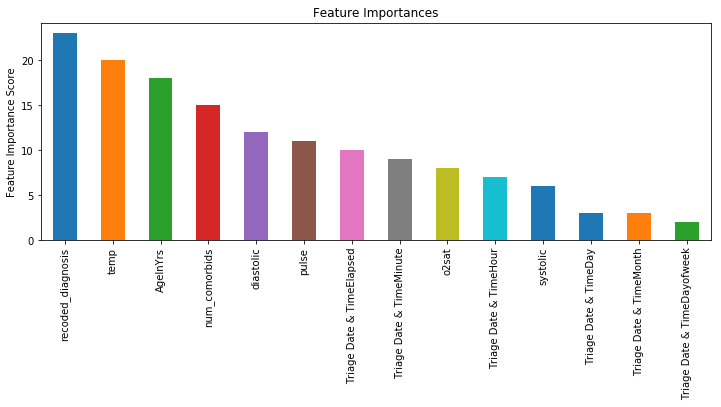

In [206]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
trained_model = modelfit(xgb1, dtrain, cont_vars, target = 'target3')

In [208]:
from sklearn.grid_search import GridSearchCV   

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [224]:
features = clin[cont_vars].values
target = clin['target3'].values
X_train, X_test, y_train, y_test = train_test_split(features[:1000], target[:1000], random_state=1)

In [225]:
#this just doesn't work.  takes too long maybe?
param_test1 = {
 'max_depth':[3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

### now we are going to repeat the process with ICU vs other target

In [103]:
X_train, X_test, y_train, y_test = train_test_split(features, clin['target5'] , random_state=1)

In [104]:
y_train.value_counts()

0.0    123871
1.0       203
Name: target5, dtype: int64

In [105]:
class_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]; class_ratio

610.2019704433498

In [110]:
results_df2, preds = JJ_gridsearch([1/900, 1/600] + weights + [600, 900])

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  '

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: too many values to unpack (expected 2)

In [111]:
results_df2

,trial number,class penalty,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,1,600,0.997752,"[0.9992499032133179, 0.0]",0.998501,"[0.9985009308735704, 0.0]","[1.0, 0.0]",1,0
1,2,90,0.997752,"[0.9992499032133179, 0.0]",0.998501,"[0.9985009308735704, 0.0]","[1.0, 0.0]",1,0
2,3,30,0.997752,"[0.9992499032133179, 0.0]",0.998501,"[0.9985009308735704, 0.0]","[1.0, 0.0]",1,0
3,4,9,0.997752,"[0.9992499032133179, 0.0]",0.998501,"[0.9985009308735704, 0.0]","[1.0, 0.0]",1,0
4,5,3,0.997752,"[0.9992499032133179, 0.0]",0.998501,"[0.9985009308735704, 0.0]","[1.0, 0.0]",1,0
5,6,1,0.997752,"[0.9992499032133179, 0.0]",0.998501,"[0.9985009308735704, 0.0]","[1.0, 0.0]",1,0
6,7,0.333333,0.99774,"[0.9992377956566452, 0.0]",0.998477,"[0.9985008946273998, 0.0]","[0.9999757851659927, 0.0]",0.999976,0
7,8,0.111111,0.997609,"[0.9990682365469089, 0.02531645569620253]",0.998138,"[0.9985245029268057, 0.058823529411764705]","[0.9996125626558829, 0.016129032258064516]",0.999613,0.016129
8,9,0.0333333,0.996516,"[0.9979769101239294, 0.023391812865497078]",0.995962,"[0.9985454545454545, 0.01834862385321101]","[0.9974090127612175, 0.03225806451612903]",0.997409,0.0322581
9,10,0.0111111,0.991154,"[0.9925806805306824, 0.04094488188976377]",0.985275,"[0.9987986073652724, 0.02268760907504363]","[0.9864396929559048, 0.20967741935483872]",0.98644,0.209677


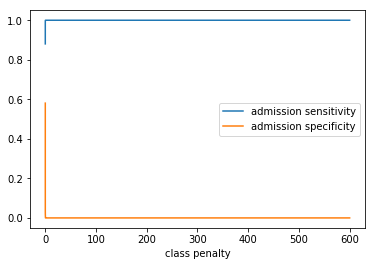

In [115]:
results_df2.plot(logx = True, x = 'class penalty', y = ['admission sensitivity', 'admission specificity'] )
plt.show()

#### now gonna see if I can incorporate some categorical variables

In [112]:
X = clin[cat_vars].values.astype(str)

features = []
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    features.append(feature)
encoded_x = np.array(features)
encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

In [77]:
target = clin['discharge']
target2 = clin['ICUvsother'] 

In [78]:
#X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [79]:
LABELS = ['admit', 'discharge'] 

In [80]:
y_train.value_counts()

discharge    111906
admit         12168
Name: discharge, dtype: int64

In [81]:
y_test.value_counts()

discharge    37312
admit         4047
Name: discharge, dtype: int64

#### first we are going to train xgb without class penalties

In [82]:
xgc = xgb.XGBClassifier()

xgc.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
preds = xgc.predict(X_test)

In [ ]:
conf = confusion_matrix(y_test, preds)
plt.figure(figsize=(3, 3))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission PPV: ', rec[1])

In [ ]:
results_df3, preds = JJ_gridsearch([1/900, 1/600] + weights + [600, 900])

#### now we are going to try to mix categorical and cont variables

In [71]:
features = np.concatenate((features, encoded_x), axis = 1)
features.shape

(165433, 4006)

In [72]:
target = clin['discharge']
target2 = clin['ICUvsother'] 

In [73]:
#X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [74]:
LABELS = ['admit', 'discharge'] 

In [75]:
xgc = xgb.XGBClassifier()

xgc.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
preds = xgc.predict(X_test)

In [ ]:
conf = confusion_matrix(y_test, preds)
plt.figure(figsize=(3, 3))
sns.heatmap(conf, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 10});

plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [ ]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
prec = sklearn.metrics.precision_score(y_test,preds, average=None) #, pos_label='admit')
rec = sklearn.metrics.recall_score(y_test,preds, average=None) #, pos_label='admit')
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)
print ('precision:   ', prec)
print ('recall:      ', rec)
print ('admission sens: ', rec[0])
print ('admission PPV: ', rec[1])

Now, we want to use bert encodings. The problem is that these are very wide, so if we used the whole array (just for clinical notes) we would have 500 rows each of length over 1000, which is a recipe for disaster. So, let's try to (a) use just clinical notes, and (b) reduce dimension for using TSNE (a nonlinear dimension reducer). It reduces dimension to 2 (which is very low indeed).

In [ ]:
tsner = TSNE()

In [ ]:
berttsne = tsner.fit_transform(train_tokens_ids)

In [46]:
tsnedf = pd.DataFrame(berttsne, index = clin.index)

In [47]:
features = pd.concat([clin[['systolic', 'diastolic', 'Pulse_LastEDReading', 'O2Saturation_LastEDReading', 'Temperature_LastEDReading', 'AgeInYrs', 'Gender']], tsnedf], axis=1)

In [48]:
xgc = xgb.XGBClassifier()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [50]:
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)

In [51]:
confusion_matrix(y_test, preds)

array([[ 0,  2,  0,  0,  0],
       [ 0, 16, 23,  1,  0],
       [ 0, 12, 57,  3,  0],
       [ 0,  2,  8,  0,  0],
       [ 0,  0,  2,  0,  0]])

We get essentially the same results as before for triage level. What about disposition?

In [52]:
xgc = xgb.XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=1)

In [53]:
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

array([[  3,   0,   4,   0,   0],
       [  0,   1,   1,   0,   0],
       [  1,   1, 112,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   2,   0,   0]])

We notice that the accuracy is the same, and the results are similar. Let us try a linear but higher-dimensional reduction.

In [54]:
pcaer = PCA(n_components=30)

In [55]:
bertpca = pcaer.fit_transform(bertnotes, None)

In [56]:
pcadf = pd.DataFrame(bertpca, index=clin.index)

In [57]:
features = pd.concat([clin[['systolic', 'diastolic', 'Pulse_LastEDReading', 'O2Saturation_LastEDReading', 'Temperature_LastEDReading', 'AgeInYrs', 'Gender']], pcadf], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

array([[ 0,  2,  0,  0,  0],
       [ 0,  9, 31,  0,  0],
       [ 0,  9, 63,  0,  0],
       [ 0,  0, 10,  0,  0],
       [ 0,  0,  2,  0,  0]])

We get worse results for triage level. What about disposition?

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

array([[  2,   0,   5,   0,   0],
       [  0,   1,   1,   0,   0],
       [  2,   0, 112,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   2,   0,   0]])

Clearly worse results.

For kicks, let us try NOT reducing dimension.

In [63]:
bertdf = pd.DataFrame(train_tokens_ids, index=clin.index)

In [64]:
features = pd.concat([clin[['systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs', 'Gender']], bertdf], axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 78, 415,   0,   0],
       [ 53, 815,   0,   0],
       [  7, 211,   0,   0],
       [  3,  91,   0,   0]])

We do get noticeably better results (77/126 = 61%).

In [136]:
X_train, X_test, y_train, y_test = train_test_split(features, target2, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[  2,   0,   5,   0,   0],
       [  0,   0,   2,   0,   0],
       [  0,   0, 114,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   2,   0,   0]])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(features, target3, random_state=1)
xgc = xgb.XGBClassifier()
xgc.fit(X_train, y_train)
preds = xgc.predict(X_test)
confusion_matrix(y_test, preds)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[1512,    4,    0,    0],
       [ 108,    6,    0,    0],
       [  36,    1,    0,    0],
       [   6,    0,    0,    0]])

But clearly bad results here (everything is classified as "go home", because xgboost is getting confused by the quantity of data. To check this, let us see if we are overfitting:

In [67]:
f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
acc = sklearn.metrics.accuracy_score(y_test, preds)
print ('weighted f1: ', f1_w)
print ('f1:          ', f1)
print ('accuracy:    ', acc)

weighted f1:  0.8687874745570356
f1:           [0.95154185 0.096      0.         0.        ]
accuracy:     0.9073520621637776


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
#second set of predictions made by running algorithom on training set
preds2 = xgc.predict(X_train)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [138]:
#comparing training features to training labels
confusion_matrix(y_train, preds2)

array([[  1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  38,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   3,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 321,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   5,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3]])

Notice that we get perfect results - a sure sign of overfitting.

Below we do experiments with medical history, but ignore this for now.

In [13]:
tsner = TSNE(perplexity=30, n_components=3)

In [14]:
berttsne = tsner.fit_transform(allbert)

In [15]:
pcadf = pd.DataFrame(bertpca, index=clin.index)
tsnedf = pd.DataFrame(berttsne, index = clin.index)

In [30]:
features = pd.concat([clin[['systolic', 'diastolic', 'Pulse_LastEDReading', 'O2Saturation_LastEDReading', 'Temperature_LastEDReading', 'AgeInYrs', 'Gender']], tsnedf], axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [33]:
xgc = xgb.XGBClassifier()

In [34]:
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [35]:
preds= xgc.predict(X_test)

In [36]:
confusion_matrix(y_test,preds)

array([[ 0,  0,  0,  0,  0],
       [ 1,  7, 27,  1,  0],
       [ 0,  7, 68,  3,  1],
       [ 0,  0,  8,  0,  0],
       [ 0,  1,  2,  0,  0]])

In [38]:
xbdc = xgb.XGBClassifier()

In [39]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target2)

In [40]:
xbdc.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [41]:
preds2 = xbdc.predict(X_test2)

In [43]:
y_test2.value_counts()

17.0    108
7.0      15
63.0      2
64.0      1
Name: DischargeDisposition, dtype: int64

In [42]:
confusion_matrix(y_test2, preds2)

array([[  2,  13,   0,   0],
       [  0, 108,   0,   0],
       [  0,   2,   0,   0],
       [  1,   0,   0,   0]])

In [47]:
clin[['DischargeDisposition', 'DischargeDispositionDesc']].head(20)

,DischargeDisposition,DischargeDispositionDesc
1,64.0,Left After Initial Assessment
2,17.0,"Discharge to private home, condo, apt without ..."
3,17.0,"Discharge to private home, condo, apt without ..."
4,17.0,"Discharge to private home, condo, apt without ..."
5,17.0,"Discharge to private home, condo, apt without ..."
6,7.0,Admit to reporting facility as inpatient to an...
7,17.0,"Discharge to private home, condo, apt without ..."
8,17.0,"Discharge to private home, condo, apt without ..."
9,17.0,"Discharge to private home, condo, apt without ..."
10,17.0,"Discharge to private home, condo, apt without ..."


In [48]:
from catboost import CatBoostClassifier, Pool


In [49]:
cm = CatBoostClassifier()

In [50]:
cm.fit(X_train, y_train)

0:	learn: 1.5815800	total: 99.8ms	remaining: 1m 39s
1:	learn: 1.5521704	total: 126ms	remaining: 1m 2s
2:	learn: 1.5276634	total: 147ms	remaining: 48.7s
3:	learn: 1.5040328	total: 164ms	remaining: 40.7s
4:	learn: 1.4842278	total: 182ms	remaining: 36.1s
5:	learn: 1.4630057	total: 198ms	remaining: 32.7s
6:	learn: 1.4414624	total: 215ms	remaining: 30.4s
7:	learn: 1.4214964	total: 228ms	remaining: 28.3s
8:	learn: 1.4044340	total: 244ms	remaining: 26.9s
9:	learn: 1.3877698	total: 257ms	remaining: 25.5s
10:	learn: 1.3718271	total: 273ms	remaining: 24.6s
11:	learn: 1.3558154	total: 289ms	remaining: 23.8s
12:	learn: 1.3408038	total: 306ms	remaining: 23.2s
13:	learn: 1.3264407	total: 309ms	remaining: 21.7s
14:	learn: 1.3119672	total: 325ms	remaining: 21.4s
15:	learn: 1.2991486	total: 338ms	remaining: 20.8s
16:	learn: 1.2871858	total: 354ms	remaining: 20.5s
17:	learn: 1.2753436	total: 370ms	remaining: 20.2s
18:	learn: 1.2627390	total: 385ms	remaining: 19.9s
19:	learn: 1.2516730	total: 401ms	remai

In [51]:
preds_class=cm.predict(X_test)

In [52]:
confusion_matrix(y_test, preds_class)

array([[ 0,  0,  0,  0,  0],
       [ 1,  7, 28,  0,  0],
       [ 0,  9, 67,  2,  1],
       [ 0,  1,  7,  0,  0],
       [ 0,  0,  3,  0,  0]])

In [61]:
cm2 = CatBoostClassifier(iterations = 20)

In [62]:
cm2.fit(X_train2, y_train2)

0:	learn: 2.0732404	total: 13.5ms	remaining: 257ms
1:	learn: 1.9416805	total: 24.8ms	remaining: 223ms
2:	learn: 1.8608578	total: 39.9ms	remaining: 226ms
3:	learn: 1.7969439	total: 56.1ms	remaining: 224ms
4:	learn: 1.7209652	total: 68.3ms	remaining: 205ms
5:	learn: 1.6560395	total: 78.4ms	remaining: 183ms
6:	learn: 1.6129643	total: 93.6ms	remaining: 174ms
7:	learn: 1.5546253	total: 119ms	remaining: 179ms
8:	learn: 1.5126407	total: 133ms	remaining: 163ms
9:	learn: 1.4676424	total: 149ms	remaining: 149ms
10:	learn: 1.4225928	total: 162ms	remaining: 132ms
11:	learn: 1.3817022	total: 171ms	remaining: 114ms
12:	learn: 1.3457852	total: 180ms	remaining: 97ms
13:	learn: 1.3144875	total: 189ms	remaining: 80.9ms
14:	learn: 1.2770894	total: 197ms	remaining: 65.8ms
15:	learn: 1.2456627	total: 206ms	remaining: 51.4ms
16:	learn: 1.2182089	total: 218ms	remaining: 38.4ms
17:	learn: 1.1860938	total: 222ms	remaining: 24.6ms
18:	learn: 1.1569956	total: 232ms	remaining: 12.2ms
19:	learn: 1.1338402	total: 2

In [63]:
preds_class2 = cm2.predict(X_test2)

In [64]:
confusion_matrix(y_test2, preds_class2)

array([[  0,  15,   0,   0],
       [  0, 108,   0,   0],
       [  0,   2,   0,   0],
       [  0,   1,   0,   0]])

In [65]:
preds_class2

array([[17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
      

In [66]:
preds2

array([17., 17., 17., 17., 17., 17., 17.,  7., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17.,  7., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17.,  7., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17.])

In [70]:
np.unique(preds_class2)

array([17.])

In [71]:
confusion_matrix(y_test2, preds2)

array([[  2,  13,   0,   0],
       [  0, 108,   0,   0],
       [  0,   2,   0,   0],
       [  1,   0,   0,   0]])